In [1]:
from scipy.interpolate import griddata
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, BatchNormalization

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2023-12-29 17:02:19.287799: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import pandas as pd
import numpy as np
import plotly.offline as pyo
from plotly import subplots
import plotly.graph_objects as go

In [6]:
client = pd.read_csv("../../data/client.csv")
ePrices = pd.read_csv("../../data/electricity_prices.csv")
gasPrices = pd.read_csv("../../data/gas_prices.csv")
train = pd.read_csv("../../data/train.csv")

In [14]:
weatherPredInt = pd.read_csv("interpolPredWeather.csv")
weatherHistInt = pd.read_csv("../histWeatherSnowCover.csv")

# process data

### merge client & train, add business feat & interpolate daylight savings

In [8]:
producing = train.loc[train.is_consumption == 0]
consuming = train.loc[train.is_consumption == 1]
train = pd.merge(producing.drop('is_consumption',axis = 1), consuming.drop('is_consumption',axis = 1),on=['data_block_id','prediction_unit_id','datetime','county','is_business','product_type'], how='outer',suffixes=('_prod', '_cons'))
del producing, consuming
print(train.shape)

clientsTime = pd.merge(train, client, on=['county','is_business','product_type','data_block_id'], how='inner')

clientsTime['datetime'] = pd.to_datetime(clientsTime['datetime'])
clientsTime['yearday'] = clientsTime['datetime'].dt.day_of_year
clientsTime['weekday'] = clientsTime['datetime'].dt.day_of_week
clientsTime['month'] = clientsTime['datetime'].dt.month
clientsTime['monthday'] = clientsTime['datetime'].dt.day
clientsTime['year'] = clientsTime['datetime'].dt.year


unique_pairs = list(set(zip(clientsTime['is_business'], clientsTime[ 'product_type'])))
pair_index_dict = {pair: index for index, pair in enumerate(unique_pairs)}
clientsTime['business_prodType'] = list(map(pair_index_dict.get, zip(clientsTime['is_business'], clientsTime['product_type'])))

unique_pairs_cust = list(set(zip(clientsTime['is_business'], clientsTime[ 'product_type'], clientsTime['county'], clientsTime['eic_count'],clientsTime['installed_capacity'])))
pair_index_dict = {pair: index for index, pair in enumerate(unique_pairs_cust)}
clientsTime['ind_customer_id'] = list(map(pair_index_dict.get, zip(clientsTime['is_business'], clientsTime['product_type'], clientsTime['county'], clientsTime['eic_count'],clientsTime['installed_capacity'])))

# interpolate daylight savings
clientsTime = clientsTime.interpolate()

(1009176, 10)


/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_52861/612832162.py:26: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.



#### holidays

In [9]:
import holidays
from datetime import date

us_holidays = holidays.EE()  # this is a dict

clientsTime['holiday'] = clientsTime['datetime'].apply(lambda s : s in us_holidays)
clientsTime['no_workday'] = ((clientsTime['holiday']) | (clientsTime['weekday'] > 4))

### prepare electric prices

In [10]:
ePrices['forecast_date'] = pd.to_datetime(ePrices['forecast_date'])

# Set 'timestamp' as the index
ePrices.set_index('forecast_date', inplace=True)

# Resample to fill missing hours
df_resampled = ePrices.resample('1H').asfreq()

# Linearly interpolate missing values
ePrices = df_resampled.interpolate(method='linear')

/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_52861/2052008978.py:10: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.



In [11]:
ePrices['euros_per_mwh'] = ePrices.euros_per_mwh.replace(4000.0, np.nan)

# Resample to fill missing hours
df_resampled = ePrices.resample('1H').asfreq()

# Linearly interpolate missing values
ePrices = df_resampled.interpolate(method='linear')

/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_52861/4094142437.py:7: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.



# write data into python arrays

In [15]:
#clientsTime, weatherPredInt, weatherHistInt, ePrices, gasPrices

featPredWeather = [
        #'latitude', 'longitude', 
        'County', #
       'hours_ahead',
        'data_block_id', #'origin_datetime', 
       'temperatureint',
       'dewpointint', 'cloudcover_highint', 'cloudcover_lowint',
       'cloudcover_midint', 'cloudcover_totalint',
       '10_metre_u_wind_componentint', '10_metre_v_wind_componentint',
       'direct_solar_radiationint', 'surface_solar_radiation_downwardsint',
       'snowfallint', 'total_precipitationint', 
       #'sunrise', 'sunset',
       #'daylight', 'minDaylight'
       ]

predWeatherComplete = weatherPredInt[featPredWeather]
del weatherPredInt

featHistWeather = [
       #'latitude', 'longitude', 
       'County',
       #
       'data_block_id', 
       'temperatureint', 'dewpointint', 'rainint',
       'snowfallint', 'surface_pressureint', 'cloudcover_totalint',
       'cloudcover_lowint', 'cloudcover_midint', 'cloudcover_highint',
       'windspeed_10mint', 'winddirection_10mint', 'shortwave_radiationint',
       'direct_solar_radiationint', 'diffuse_radiationint', 'meltingInCM',
       'snowHeightFlux', 'snowcover',
]
histWeatherComplete = weatherHistInt[featHistWeather]
del weatherHistInt



# loop over customer, append all data cycles for each customer
dataArray = []
for businessProdTypeId in clientsTime.business_prodType.unique():
    busProdSlice = clientsTime.loc[clientsTime.business_prodType == businessProdTypeId]

    constValsArray = np.zeros((1,17))
    targetsArray = np.zeros((1,24,2))
    ePricesArray = np.zeros((1,24,1))

    nFeatHistWeather = histWeatherComplete.shape[1]-1
    histWeatherArray = np.zeros((1,24,nFeatHistWeather))
    nFeatPredWeather = predWeatherComplete.shape[1]-1
    predWeatherArray = np.zeros((1,24,nFeatPredWeather))
    dataBlockIdArray = np.zeros((1))

    y = np.zeros((busProdSlice.shape[0],2))

    for customerId in busProdSlice.ind_customer_id.unique():
        customerSlice = busProdSlice.loc[busProdSlice.ind_customer_id == customerId]

        for dataBlockId in customerSlice.data_block_id.unique():
            timeSlice = customerSlice.loc[customerSlice.data_block_id == dataBlockId]
            gasSlice = gasPrices.loc[gasPrices.data_block_id == dataBlockId]
            eSlice   = ePrices.loc[ePrices.data_block_id == dataBlockId]

            if len(timeSlice.yearday.unique()) > 1:
                print(timeSlice.yearday.unique())

            # const values
            yearday = timeSlice.yearday.unique()[0]
            weekday = timeSlice.weekday.unique()[0]
            month   = timeSlice.month.unique()[0]
            monthday = timeSlice.monthday.unique()[0]
            year = timeSlice.year.unique()[0]

            county       = customerSlice.county.unique()[0]
            is_business  = customerSlice.is_business.unique()[0]
            product_type = customerSlice.product_type.unique()[0]
            prediction_unit_id = customerSlice.prediction_unit_id.unique()[0] #should be redundant
            eic_count          = customerSlice.eic_count.unique()[0]
            installed_capacity = customerSlice.installed_capacity.unique()[0]

            business_prodType = customerSlice.business_prodType.unique()[0]
            ind_customer_id   = customerSlice.ind_customer_id.unique()[0]

            holiday = timeSlice.holiday.unique()[0]
            noWorkDay = timeSlice.no_workday.unique()[0]



            lowest_price_per_mwh = gasSlice.lowest_price_per_mwh.iloc[0]
            highest_price_per_mwh = gasSlice.highest_price_per_mwh.iloc[0]
            euros_per_mwh = eSlice['euros_per_mwh'].to_numpy()
            if euros_per_mwh.shape[0] == 23:
                print(dataBlockId, customerId)

            y_cons = timeSlice['target_cons'] / installed_capacity
            y_prod = timeSlice['target_prod'] / installed_capacity

            histWeather = histWeatherComplete.loc[(histWeatherComplete.data_block_id == dataBlockId) & (histWeatherComplete.County == county)]
            predWeather = predWeatherComplete.loc[(predWeatherComplete.data_block_id == dataBlockId) & (predWeatherComplete.County == county)]

            histWeather = histWeather.drop('data_block_id', axis = 1)
            predWeather = predWeather.drop('data_block_id', axis = 1)


            if y_cons.shape[0] == 23:
                print(dataBlockId, customerId)

            new_row = np.array([county, is_business, product_type, prediction_unit_id, eic_count, installed_capacity, 
            business_prodType,ind_customer_id,lowest_price_per_mwh,highest_price_per_mwh,
            yearday,weekday,month,monthday,year,holiday,noWorkDay
            ])
            constValsArray = np.vstack((constValsArray, new_row))

            new_row = np.zeros((1,24,2))
            new_row[:,:,0] = y_cons
            new_row[:,:,1] = y_prod
            targetsArray = np.concatenate((targetsArray, new_row), axis=0)

            new_row = np.zeros((1,24,1))
            new_row[0,:,0] = euros_per_mwh
            ePricesArray = np.concatenate((ePricesArray, new_row), axis=0)

            new_row = np.zeros((1,24,nFeatHistWeather)) #without datablock id
            new_row[:,:,:] = histWeather
            histWeatherArray = np.concatenate((histWeatherArray, new_row), axis=0)

            new_row = np.zeros((1,24,nFeatPredWeather)) # withotu datablock id
            new_row[:,:,:] = predWeather
            predWeatherArray = np.concatenate((predWeatherArray, new_row), axis=0)

            dataBlockIdArray = np.concatenate((dataBlockIdArray, np.array([dataBlockId])))
    
    #remove first rows
    targetsArray     = targetsArray[1:,:,:]
    constValsArray   = constValsArray[1:,:]
    ePricesArray     = ePricesArray[1:,:,:]
    histWeatherArray = histWeatherArray[1:,:,:]
    predWeatherArray = predWeatherArray[1:,:,:]
    dataBlockIdArray = dataBlockIdArray[1:]

    targetsAbs = targetsArray.copy()
    targetsAbs = targetsAbs * constValsArray[:,5].reshape(constValsArray.shape[0],1,1)

    dataArray.append([constValsArray,ePricesArray,histWeatherArray,predWeatherArray,targetsAbs,targetsArray,dataBlockIdArray, businessProdTypeId])


In [16]:
# save arrays and check shape
for i in range (0,7):
    print(dataArray[i][7])
    print(dataArray[i][0].shape,dataArray[i][1].shape,dataArray[i][2].shape,dataArray[i][3].shape,dataArray[i][4].shape,dataArray[i][5].shape,dataArray[i][6].shape)
    np.savez('data_arrays_businessTypeSpread'+str(i)+'.npz', arr1=dataArray[i][0], arr2=dataArray[i][1], arr3=dataArray[i][2], arr4 = dataArray[i][3], arr5=dataArray[i][4], arr6=dataArray[i][5], arr7=dataArray[i][6], arr8=dataArray[i][7])

0
(8874, 17) (8874, 24, 1) (8874, 24, 18) (8874, 24, 14) (8874, 24, 2) (8874, 24, 2) (8874,)
4
(1620, 17) (1620, 24, 1) (1620, 24, 18) (1620, 24, 14) (1620, 24, 2) (1620, 24, 2) (1620,)
3
(8904, 17) (8904, 24, 1) (8904, 24, 18) (8904, 24, 14) (8904, 24, 2) (8904, 24, 2) (8904,)
5
(3539, 17) (3539, 24, 1) (3539, 24, 18) (3539, 24, 14) (3539, 24, 2) (3539, 24, 2) (3539,)
2
(7358, 17) (7358, 24, 1) (7358, 24, 18) (7358, 24, 14) (7358, 24, 2) (7358, 24, 2) (7358,)
6
(10176, 17) (10176, 24, 1) (10176, 24, 18) (10176, 24, 14) (10176, 24, 2) (10176, 24, 2) (10176,)
1
(1398, 17) (1398, 24, 1) (1398, 24, 18) (1398, 24, 14) (1398, 24, 2) (1398, 24, 2) (1398,)


# load data

In [18]:
dataArray = []
for i in range (0,7):
    loaded_data = np.load('data_arrays_businessTypeSpread'+str(i)+'.npz')
    dataArray.append([loaded_data['arr1'],loaded_data['arr2'],loaded_data['arr3'],loaded_data['arr4'],loaded_data['arr5'],loaded_data['arr6'],loaded_data['arr7'],loaded_data['arr8']])
    print(dataArray[i][7])
    print(dataArray[i][0].shape,dataArray[i][1].shape,dataArray[i][2].shape,dataArray[i][3].shape,dataArray[i][4].shape,dataArray[i][5].shape,dataArray[i][6].shape)

0
(8874, 17) (8874, 24, 1) (8874, 24, 18) (8874, 24, 14) (8874, 24, 2) (8874, 24, 2) (8874,)
4
(1620, 17) (1620, 24, 1) (1620, 24, 18) (1620, 24, 14) (1620, 24, 2) (1620, 24, 2) (1620,)
3
(8904, 17) (8904, 24, 1) (8904, 24, 18) (8904, 24, 14) (8904, 24, 2) (8904, 24, 2) (8904,)
5
(3539, 17) (3539, 24, 1) (3539, 24, 18) (3539, 24, 14) (3539, 24, 2) (3539, 24, 2) (3539,)
2
(7358, 17) (7358, 24, 1) (7358, 24, 18) (7358, 24, 14) (7358, 24, 2) (7358, 24, 2) (7358,)
6
(10176, 17) (10176, 24, 1) (10176, 24, 18) (10176, 24, 14) (10176, 24, 2) (10176, 24, 2) (10176,)
1
(1398, 17) (1398, 24, 1) (1398, 24, 18) (1398, 24, 14) (1398, 24, 2) (1398, 24, 2) (1398,)


# split arrays into different models

In [79]:
dataArrId = 6 #determine which index in the list I want to process

# 0: 23/47     -> 0
# 1: 13/11     -> 4
# 2: 83/143    -> 3
# 3: 250/311   -> 5
# 4: 106/150   -> 2
# 5: 603/666   -> 6
# 6: 25/53     -> 1

constValsArray   = dataArray[dataArrId][0]
ePricesArray     = dataArray[dataArrId][1]
histWeatherArray = dataArray[dataArrId][2]
predWeatherArray = dataArray[dataArrId][3]
targetsAbs       = dataArray[dataArrId][4]
targetsArray     = dataArray[dataArrId][5]
dataBlockIdArray = dataArray[dataArrId][6]
businessProdTypeId = dataArray[dataArrId][7]

# preselect data

In [80]:
featPredWeather = [
        'County',
       'hours_ahead',
       # 'data_block_id',
       'temperatureint',
       'dewpointint', 'cloudcover_highint', 'cloudcover_lowint',
       'cloudcover_midint', 
       'cloudcover_totalint',
       '10_metre_u_wind_componentint', '10_metre_v_wind_componentint',
       'direct_solar_radiationint', 'surface_solar_radiation_downwardsint',
       'snowfallint', 'total_precipitationint', 
       ]
featPredWeatherKeepIdx = [0,1,2,3,4,5,6,10,11,12,13]
predWeatherArray=predWeatherArray[:,:,featPredWeatherKeepIdx]
featPredWeather = [featPredWeather[i] for i in featPredWeatherKeepIdx]

#correct hours
predWeatherArray[:,:,1] = predWeatherArray[:,:,1] - 24

# add sin of hours
sinDay = np.reshape(np.sin((predWeatherArray[:,:,1] - 24)*np.pi/24),(predWeatherArray.shape[0],predWeatherArray.shape[1],1))
predWeatherArray = np.concatenate((predWeatherArray, sinDay), axis=2)
featPredWeatherKeepIdx = featPredWeatherKeepIdx + [len(featPredWeatherKeepIdx)] 
featPredWeather = featPredWeather + ['sinDay']

cosDay = np.reshape(np.cos((predWeatherArray[:,:,1] - 24)*np.pi/24),(predWeatherArray.shape[0],predWeatherArray.shape[1],1))
predWeatherArray = np.concatenate((predWeatherArray, cosDay), axis=2)
featPredWeatherKeepIdx = featPredWeatherKeepIdx + [len(featPredWeatherKeepIdx)] 
featPredWeather = featPredWeather + ['cosDay']
nPredFeat = predWeatherArray.shape[2]

featPredWeatherKeepIdx = [2,3,13,14,15]




featConst =['county', 'is_business', 'product_type', 'prediction_unit_id', 'eic_count', 'installed_capacity', 'business_prodType', 'ind_customer_id',
'lowest_price_per_mwh','highest_price_per_mwh','yearday','weekday','month','monthday','year','holiday','no_workday'
]

featConstKeepIdx = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

# add sin of year day
yeardayIdx = featConstKeepIdx.index(10)
CapIdx = featConstKeepIdx.index(5)
sinYear = np.reshape(np.sin(2*constValsArray[:,yeardayIdx]*np.pi/365),(constValsArray.shape[0],1))
constValsArray = np.concatenate((constValsArray, sinYear), axis=1)
featConst = featConst + ['sinYearDay']

cosYear = np.reshape(np.cos(2*constValsArray[:,yeardayIdx]*np.pi/365),(constValsArray.shape[0],1))
constValsArray = np.concatenate((constValsArray, cosYear), axis=1)
featConst = featConst + ['cosYearDay']




#featConstKeepIdx = [0,1,2,5,6,8,9,13,16,17,18]
constValsArray=constValsArray[:,featConstKeepIdx]
featConst = [featConst[i] for i in featConstKeepIdx]
nConst = constValsArray.shape[1]



featHistWeather = [
       'County', 
       #'data_block_id', 
       'temperatureint', 'dewpointint', 'rainint',
       'snowfallint', 'surface_pressureint', 'cloudcover_totalint',
       'cloudcover_lowint', 'cloudcover_midint', 'cloudcover_highint',
       'windspeed_10mint', 'winddirection_10mint', 'shortwave_radiationint',
       'direct_solar_radiationint', 'diffuse_radiationint', 'meltingInCM',
       'snowHeightFlux', 'snowcover'
]
featHistWeatherKeepIdx = [1,10]
histWeatherArray=histWeatherArray[:,:,featHistWeatherKeepIdx]

featHistWeather = [featHistWeather[i] for i in featHistWeatherKeepIdx]
nHistFeat = histWeatherArray.shape[2]


targetsAbs[:,0] = targetsAbs[:,0]#-800

print(nPredFeat,nHistFeat,nConst)

13 2 15


In [122]:
from sklearn.preprocessing import LabelEncoder

# Assuming cat_feature is a categorical feature
encoder = LabelEncoder()
constValsArray[:,eicCountIdx] = encoder.fit_transform(constValsArray[:,eicCountIdx])

# build a model & train it

In [21]:
tf.random.set_seed(42)
from sklearn.model_selection import train_test_split

### shuffle if needed & split into x train y train

In [81]:
trainSplit = int(max(dataBlockIdArray)*0.5)
mask = dataBlockIdArray < trainSplit

shuffledArr = [constValsArray,ePricesArray,histWeatherArray,predWeatherArray,targetsAbs,targetsArray,dataBlockIdArray]


X_train = [shuffledArr[0][mask],shuffledArr[1][mask],shuffledArr[2][mask],shuffledArr[3][mask]]
# only const and e prices
X_train = [shuffledArr[0][mask]]#,shuffledArr[1][mask]]#,shuffledArr[3][mask]]
y_trainAbs = shuffledArr[4][mask]
y_train = shuffledArr[5][mask]

X_test = [shuffledArr[0][~mask]]#,shuffledArr[1][~mask],shuffledArr[3][~mask]]
y_testAbs = shuffledArr[4][~mask]
y_test = shuffledArr[5][~mask]

#### calculate class weights

In [29]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(X_train[0][:,yeardayIdx]), y=X_train[0][:,yeardayIdx])

class_weight_dict = dict(enumerate(class_weights))

#### use standard scaler for train data

In [127]:
# normalize the target
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[0] = scaler.fit_transform(X_train[0])
X_test[0]  = scaler.transform(X_test[0])

### define consumption model & train it

In [82]:
#consumption

#weatherPred_inputs2 = tf.keras.Input(shape=(24, 6), name='weatherPred_inputs2')
#ePrices_inputs2 = tf.keras.Input(shape=(24, 1), name='ePrices_inputs2')
#weatherHist_input2 = tf.keras.Input(shape=(24, 2), name='weatherHist_input2')
constant_inputs2 = tf.keras.Input(shape=(nConst,), name='constant_inputs2')

#eatherPred_inputs2_normalized = BatchNormalization()(weatherPred_inputs2)
#ePrices_inputs2_normalized = BatchNormalization()(ePrices_inputs2)
#weatherHist_input2_normalized = BatchNormalization()(weatherHist_input2)

#constant_inputs2_normalized = BatchNormalization()(constant_inputs2)


#weatherPred_flattened2 = layers.Flatten()(weatherPred_inputs2_normalized)
#for i in range(0,3):
#    weatherPred_flattened2 = layers.Dense(144, activation='relu')(weatherPred_flattened2)
#
#weatherHist_flattened2 = layers.Flatten()(weatherHist_input2_normalized)
#for i in range(0,3):
#    weatherHist_flattened2 = layers.Dense(48, activation='relu')(weatherHist_flattened2)

#ePrices_layer2 = layers.Flatten()(ePrices_inputs2_normalized)
#for i in range(0,1):
#    ePrices_layer2 = layers.Dense(24, activation='relu')(ePrices_layer2)

constInp_layer2 = layers.Dense(nConst, activation='relu')(constant_inputs2)
for i in range(0,0):
    constInp_layer2 = layers.Dense(16, activation='relu')(constInp_layer2)

# Concatenate all inputs
#x2 = layers.Concatenate()([weatherPred_flattened2, weatherHist_flattened2, ePrices_layer2, constInp_layer2])
x2 = layers.Concatenate()([constInp_layer2])

# Main dense block
for i in range(0,1):
    x2 = layers.Dense(15, activation='relu')(x2) #making it bigger helps a bit, but not super significant
    #x = layers.Dropout(0.1)(x)

#x2 = layers.Dense(256, activation='relu')(x2)
#x2 = layers.Dense(128, activation='relu')(x2)
#x2 = layers.Dense(64, activation='relu')(x2)

# Output layer for 24*2 targets
output_layer2 = layers.Dense(24 * 1, activation='relu', name='output')(x2)
#output_layer2 = layers.Reshape((24, 1))(output_layer2)

#model3 = tf.keras.Model(inputs=[constant_inputs2,ePrices_inputs2, weatherHist_input2, weatherPred_inputs2], outputs=output_layer2)
model3 = tf.keras.Model(inputs=[constant_inputs2], outputs=output_layer2)

def absolute_loss(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_true - y_pred))

# Compile the model with an appropriate loss function and optimizer
model3.compile(optimizer='adam', loss='mae')#, metrics=['mae'])
# 0 = cons, 1 = prod
#history3 = model3.fit(X_train, y_trainAbsN_cons, validation_data=(X_test, y_testAbsN_cons), epochs=100, batch_size=250)
#model3.optimizer.lr.assign(0.01)
history3 = model3.fit(X_train, y_trainAbs[:,:,0], validation_data=(X_test, y_testAbs[:,:,0]), epochs=500, batch_size=10000)#, class_weight=class_weight_dict)

Epoch 1/500
1/1 [==============================] - 0s 331ms/step - loss: 67.7868 - val_loss: 77.4552
Epoch 2/500
1/1 [==============================] - 0s 26ms/step - loss: 66.6391 - val_loss: 76.5106
Epoch 3/500
1/1 [==============================] - 0s 27ms/step - loss: 65.5054 - val_loss: 75.5839
Epoch 4/500
1/1 [==============================] - 0s 28ms/step - loss: 64.3963 - val_loss: 74.6818
Epoch 5/500
1/1 [==============================] - 0s 28ms/step - loss: 63.3032 - val_loss: 73.8061
Epoch 6/500
1/1 [==============================] - 0s 27ms/step - loss: 62.2300 - val_loss: 72.9463
Epoch 7/500
1/1 [==============================] - 0s 26ms/step - loss: 61.1718 - val_loss: 72.1083
Epoch 8/500
1/1 [==============================] - 0s 28ms/step - loss: 60.1351 - val_loss: 71.3014
Epoch 9/500
1/1 [==============================] - 0s 26ms/step - loss: 59.1335 - val_loss: 70.5276
Epoch 10/500
1/1 [==============================] - 0s 25ms/step - loss: 58.1732 - val_loss: 69.778

In [86]:
history3 = model3.fit(X_train, y_trainAbs[:,:,0], validation_data=(X_test, y_testAbs[:,:,0]), epochs=200, batch_size=10000)

Epoch 1/200
1/1 [==============================] - 0s 49ms/step - loss: 25.5765 - val_loss: 54.7416
Epoch 2/200
1/1 [==============================] - 0s 25ms/step - loss: 25.5738 - val_loss: 54.7169
Epoch 3/200
1/1 [==============================] - 0s 28ms/step - loss: 25.5715 - val_loss: 54.7118
Epoch 4/200
1/1 [==============================] - 0s 28ms/step - loss: 25.5702 - val_loss: 54.7408
Epoch 5/200
1/1 [==============================] - 0s 28ms/step - loss: 25.5696 - val_loss: 54.6977
Epoch 6/200
1/1 [==============================] - 0s 31ms/step - loss: 25.5691 - val_loss: 54.7431
Epoch 7/200
1/1 [==============================] - 0s 24ms/step - loss: 25.5683 - val_loss: 54.7243
Epoch 8/200
1/1 [==============================] - 0s 25ms/step - loss: 25.5653 - val_loss: 54.7558
Epoch 9/200
1/1 [==============================] - 0s 25ms/step - loss: 25.5635 - val_loss: 54.7449
Epoch 10/200
1/1 [==============================] - 0s 27ms/step - loss: 25.5622 - val_loss: 54.7458

In [83]:
fig = go.Figure()
length = len(history3.history['loss'])
fig.add_trace(go.Scatter(x=np.arange(1, length+1), y=history3.history['loss'], mode='lines', name='Train Loss'))
fig.add_trace(go.Scatter(x=np.arange(1, length+1), y=history3.history['val_loss'], mode='lines', name='Validation Loss'))
fig.update_layout(
    title='Training and Validation Loss Over Epochs',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    legend=dict(x=0, y=1, traceorder='normal'),
)
fig.show()

In [112]:
#relative reversal
a = model3.predict(X_test)
predVals = a*X_test[0][:,5].reshape(X_test[0].shape[0],1)
print(np.mean(np.abs(y_testAbs[:,:,0] - predVals)))
a = model3.predict(X_train)
predVals = a*X_train[0][:,5].reshape(X_train[0].shape[0],1)
trueVals = targetsAbs[0:trainSplit,:]
print(np.mean(np.abs(y_trainAbs[:,:,0]  - predVals)))
del a,predVals,trueVals

# 34/67

# mean cons error single traines =35-37 (train) 53-57 (test) -> 34/63 -> 32/55
# mean prod error single trainer = 9-20 -> 10/18

56/56 [==============================] - 0s 719us/step
98.07265090362891
222/222 [==============================] - 0s 776us/step
61.49718896217027


In [437]:
#scaler reversal
a = model3.predict(X_test)
predVals = scalerT.inverse_transform(a.reshape(-1,1))
print(np.mean(np.abs(y_testAbs[:,:,0] - predVals.reshape(-1,24))))
a = model3.predict(X_train)
predVals = scalerT.inverse_transform(a.reshape(-1,1))
trueVals = targetsAbs[0:trainSplit,:]
print(np.mean(np.abs(y_trainAbs[:,:,0]  - predVals.reshape(-1,24))))
del a,predVals,trueVals

262/262 [==============================] - 1s 2ms/step
48.30298230000601
1047/1047 [==============================] - 2s 2ms/step
32.49173357953375


In [ ]:
model2.save('prod_model_GasPr_noSunrise_timeFeat.h5')
model3.save('cons_model_GasPr_noSunrise_timeFeat.h5')

# reconstruct dataframe and analyse results

In [30]:
# restructure dataframes, SHOULD BE CONST IF WE DON'T CHANGE MASK & NOT SHUFFLE
appendedList = []
shuffledDataBlockId = shuffledArr[6]
for i,data_block_id in enumerate(shuffledDataBlockId):
    isTrain = mask[i]
    
    new_columns = np.zeros((24, 2))  # Adjust the size according to your requirements

    #use targets as first block
    dataBlock = shuffledArr[4][i,:,:].reshape(24,2)

    #add train/test info & data block id
    new_columns = np.ones((24, 2)) * [isTrain, data_block_id]
    dataBlock = np.hstack((dataBlock, new_columns))
    #add const values
    new_columns = np.ones((24, nConst)) * shuffledArr[0][i,:].reshape(1,nConst)
    dataBlock = np.hstack((dataBlock, new_columns))
    #eprices (of yesterday)
    dataBlock = np.hstack((dataBlock, shuffledArr[1][i,:,:].reshape(24,1)))
    # add weather prediction
    dataBlock = np.hstack((dataBlock, shuffledArr[3][i,:,:].reshape(24,len(featPredWeatherKeepIdx))))
    # hist weather
    dataBlock = np.hstack((dataBlock, shuffledArr[2][i,:,:].reshape(24,len(featHistWeatherKeepIdx))))

    #hist weather, flatten the array and add all values as columns
    #new_columns = np.ones((24, 100)) * shuffledArr[2][i,:].reshape(1,100)
    #dataBlock = np.hstack((dataBlock, new_columns))

    appendedList.append(dataBlock)




feat = ['y_cons','y_prod','isTrain','data_block_id'] + featConst + ['ePrices'] + featPredWeather + featHistWeather
#for i in range(0,10):
#    feat = feat + [f'{value}_'+str(i) for value in featHistWeather]

appendedDf = pd.DataFrame(np.vstack(appendedList), columns=feat)

from datetime import datetime, timedelta
appendedDf['unique_time'] = appendedDf.apply(lambda row: datetime(row['year'].astype(int), 1, 1) + timedelta(days=row['yearday'] - 1, hours=row['hours_ahead']-24), axis=1)
#appendedDf['unique_time'] = appendedDf.apply(lambda row: datetime(2022, 1, 1) + timedelta(days=row['yearday'] - 1, hours=row['hours_ahead']-24), axis=1)
    
            

In [144]:
X2 = [shuffledArr[0],shuffledArr[1],shuffledArr[2],shuffledArr[3]]
X2 = [shuffledArr[0]]#,shuffledArr[1]]
X2[0]  = scaler.transform(X2[0])
pred_cons = model3.predict(X2)
#pred_cons = pred_cons*X2[0][:,5].reshape(X2[0].shape[0],1)
#pred_cons = scalerT.inverse_transform(pred_cons.reshape(-1,1)).reshape(-1,24,1)

appendedListProd = []
for i in range(0,pred_cons.shape[0]):
    appendedListProd.append(pred_cons[i,:].reshape(1,1))
    
appendedDf['pred_cons'] = np.vstack(appendedListProd)

appendedDf['absErr_cons'] = (appendedDf['y_cons']-appendedDf['pred_cons'])



278/278 [==============================] - 0s 468us/step


# analyze dataframe
good generalization, test and train are pretty much always the same

production:
- overweighting big producers -> lots of errors for smaller capacities

consumption:
- bigger error in summer


In [145]:
trainDf = appendedDf.loc[appendedDf.isTrain == True]
testDf = appendedDf.loc[appendedDf.isTrain == False]

### investigate consumption
- some heavy overestimation (when no consumption but we predict one)
- some heave underestimation, when lots of consumption but no prediciton

we can't fit yearly trend!!
things that don't help:
- relu activation function doesn't help (but makes targets all positive)
- input normalization
- target normalization
- bigger network
- using less features to predict
- using weights on day doesn't help (but is definitely needed)


it seems that the consumption data is very sparse & hence really hard to fit 
-> try to find a normalization criteria


In [146]:
print(testDf.y_cons.mean(),testDf.y_cons.std())
print(testDf.pred_cons.mean(),testDf.pred_cons.std())

print(trainDf.y_cons.mean(),trainDf.y_cons.std())
print(trainDf.pred_cons.mean(),trainDf.pred_cons.std())

91.07441503267974 172.31711774293464
102.45742 179.31329345703125
47.26264147133949 77.29499531039082
45.64889 72.93318939208984


In [94]:
print(trainDf.y_cons.std()/trainDf.y_cons.mean())
print(trainDf.pred_cons.std()/trainDf.pred_cons.mean())

2.045087782743313
0.19442720043900094


In [55]:
trainDf.groupby('hours_ahead')[['absErr_cons','pred_cons','y_cons']].mean().plot()

KeyError: 'hours_ahead'

<Axes: xlabel='hours_ahead'>

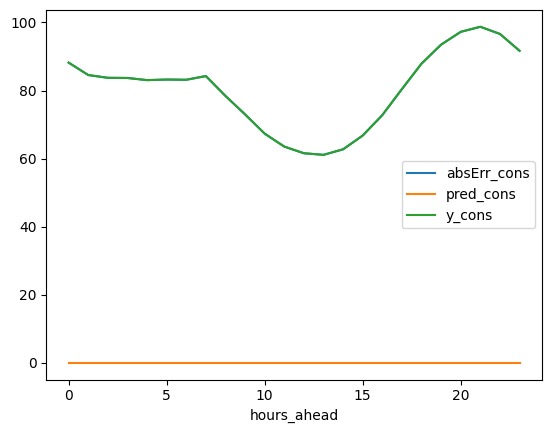

In [115]:
trainDf.groupby('hours_ahead')[['absErr_cons','pred_cons','y_cons']].std().plot()

<Axes: xlabel='unique_time'>

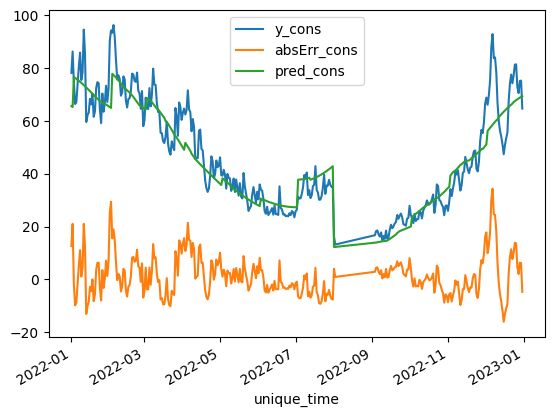

In [147]:
trainDf.groupby('unique_time')[['y_cons','absErr_cons','pred_cons']].mean().plot() #,'cosYearDay'
#trainDf.groupby('unique_time')[['y_cons']].mean().plot()

In [27]:
trainDf.columns

Index(['y_cons', 'y_prod', 'isTrain', 'data_block_id', 'county', 'is_business',
       'product_type', 'prediction_unit_id', 'eic_count', 'installed_capacity',
       'business_prodType', 'ind_customer_id', 'lowest_price_per_mwh',
       'highest_price_per_mwh', 'yearday', 'weekday', 'month', 'monthday',
       'sinYearDay', 'cosYearDay', 'ePrices', 'hours_ahead', 'temperatureint',
       'dewpointint', 'total_precipitationint', 'sinDay', 'cosDay',
       'temperatureint', 'windspeed_10mint', 'unique_time', 'pred_cons',
       'absErr_cons', 'normCons'],
      dtype='object')

In [148]:
testDf = testDf.sort_values(by='unique_time')
testDf['normCons'] = testDf['y_cons']/testDf['installed_capacity']
a = testDf.loc[(testDf.yearday >0) & (testDf.yearday < 30)]

fig = subplots.make_subplots(rows=1, cols=1,shared_xaxes=True)

fig.add_trace(go.Scatter(x = a['unique_time'], y = a['y_cons'],mode ='markers', name='y_cons'),row=1, col=1)
fig.add_trace(go.Scatter(x = a['unique_time'], y = a['pred_cons'],mode ='markers', name='pred_cons'),row=1, col=1)
fig.add_trace(go.Scatter(x = a['unique_time'], y = a['normCons'],mode ='markers', name='normCons'),row=1, col=1)
#fig.add_trace(go.Scatter(x = a['unique_time'], y = a['normConsProd'],mode ='markers', name='normConsProd'),row=1, col=1)
fig.show()


/Users/matthiaskargl/opt/anaconda3/envs/predictenegycons/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [118]:
a.loc[(a.yearday == 1) & (a.hours_ahead == 2)][['y_cons','y_prod','pred_cons','normCons'] + featConst]

,y_cons,y_prod,pred_cons,normCons,eic_count,installed_capacity,yearday
156914,39.736,1.467,533.357483,0.100547,36.0,395.20,1.0
155426,656.266,0.000,533.357483,0.164022,417.0,4001.08,1.0
145274,17.460,0.000,533.357483,0.127176,17.0,137.29,1.0
160298,55.678,0.000,533.357483,0.094355,58.0,590.09,1.0
156170,36.281,0.000,533.357483,0.136605,26.0,265.59,1.0
159146,33.049,0.000,533.357483,0.059601,17.0,554.50,1.0
161042,182.803,0.000,533.357483,0.128400,137.0,1423.70,1.0
162866,64.805,0.000,533.357483,0.118322,50.0,547.70,1.0
157658,67.406,2.359,533.357483,0.116821,55.0,577.00,1.0
153242,13.339,0.000,533.357483,0.075490,17.0,176.70,1.0


In [48]:
testDf.columns

Index(['y_cons', 'y_prod', 'isTrain', 'data_block_id', 'county', 'is_business',
       'product_type', 'prediction_unit_id', 'eic_count', 'installed_capacity',
       'business_prodType', 'ind_customer_id', 'lowest_price_per_mwh',
       'highest_price_per_mwh', 'yearday', 'weekday', 'month', 'monthday',
       'year', 'sinYearDay', 'cosYearDay', 'ePrices', 'County', 'hours_ahead',
       'temperatureint', 'dewpointint', 'cloudcover_highint',
       'cloudcover_lowint', 'cloudcover_midint', 'direct_solar_radiationint',
       'surface_solar_radiation_downwardsint', 'snowfallint',
       'total_precipitationint', 'sinDay', 'cosDay', 'County',
       'temperatureint', 'dewpointint', 'rainint', 'snowfallint',
       'surface_pressureint', 'cloudcover_totalint', 'cloudcover_lowint',
       'cloudcover_midint', 'cloudcover_highint', 'windspeed_10mint',
       'winddirection_10mint', 'shortwave_radiationint',
       'direct_solar_radiationint', 'diffuse_radiationint', 'meltingInCM',
       '

In [49]:
testDf.loc[(testDf.yearday == 7) & (testDf.hours_ahead == 5) ]

,y_cons,y_prod,isTrain,data_block_id,county,is_business,product_type,prediction_unit_id,eic_count,installed_capacity,...,winddirection_10mint,shortwave_radiationint,direct_solar_radiationint,diffuse_radiationint,meltingInCM,snowHeightFlux,snowcover,unique_time,pred_cons,absErr_cons
208373,61.102,0.0,0.0,128.0,9.0,0.0,1.0,34.0,32.0,352.7,...,239.844540,46.774320,16.844035,29.930285,-0.000000,0.000000,13.379785,2022-01-06 05:00:00,35.039268,26.062732
188597,18.849,0.0,0.0,128.0,8.0,0.0,1.0,31.0,12.0,95.5,...,188.709691,38.783299,14.337673,24.445626,-0.000000,0.000000,19.689343,2022-01-06 05:00:00,35.039268,-16.190268
185237,14.706,0.0,0.0,128.0,13.0,0.0,1.0,50.0,13.0,143.2,...,213.471059,45.000000,16.330386,28.669614,-0.005104,-0.005104,16.597745,2022-01-06 05:00:00,35.039268,-20.333268
198533,97.094,0.0,0.0,128.0,11.0,0.0,1.0,43.0,64.0,620.7,...,191.090990,39.220199,15.960265,23.259934,-0.000000,0.000000,19.760496,2022-01-06 05:00:00,35.039268,62.054732


In [274]:
pd.set_option('Display.max_columns', None)
pd.set_option('Display.max_rows', None)
cond = (testDf.data_block_id == 469) & (testDf.prediction_unit_id == 5) & (testDf.county == 0)
cond = (testDf.data_block_id == 495) & (testDf.prediction_unit_id == 21) & (testDf.county == 5)
testDf.loc[cond]

#pd.set_option('Display.max_columns', 10)
#pd.set_option('Display.max_rows', 10)


,y_cons,y_prod,isTrain,data_block_id,county,is_business,product_type,prediction_unit_id,eic_count,installed_capacity,business_prodType,ind_customer_id,lowest_price_per_mwh,highest_price_per_mwh,yearday,weekday,month,monthday,ePrices,County,hours_ahead,County,temperatureint,pred_cons,absErr_cons
527040,177.00,0.0,0.0,495.0,5.0,1.0,0.0,21.0,9.0,505.6,5.0,599.0,76.0,82.95,9.0,0.0,1.0,9.0,24.44,5.0,0.0,5.0,-14.458581,297.226837,-120.226837
527041,169.25,0.0,0.0,495.0,5.0,1.0,0.0,21.0,9.0,505.6,5.0,599.0,76.0,82.95,9.0,0.0,1.0,9.0,52.50,5.0,1.0,5.0,-14.106949,287.167328,-117.917328
527042,126.40,0.0,0.0,495.0,5.0,1.0,0.0,21.0,9.0,505.6,5.0,599.0,76.0,82.95,9.0,0.0,1.0,9.0,46.16,5.0,2.0,5.0,-13.669215,286.255219,-159.855219
527043,170.37,0.0,0.0,495.0,5.0,1.0,0.0,21.0,9.0,505.6,5.0,599.0,76.0,82.95,9.0,0.0,1.0,9.0,34.41,5.0,3.0,5.0,-13.369215,283.637512,-113.267512
527044,242.11,0.0,0.0,495.0,5.0,1.0,0.0,21.0,9.0,505.6,5.0,599.0,76.0,82.95,9.0,0.0,1.0,9.0,44.38,5.0,4.0,5.0,-13.231482,287.126007,-45.016007
527045,266.68,0.0,0.0,495.0,5.0,1.0,0.0,21.0,9.0,505.6,5.0,599.0,76.0,82.95,9.0,0.0,1.0,9.0,9.92,5.0,5.0,5.0,-13.262615,286.621735,-19.941735
527046,264.38,0.0,0.0,495.0,5.0,1.0,0.0,21.0,9.0,505.6,5.0,599.0,76.0,82.95,9.0,0.0,1.0,9.0,49.71,5.0,6.0,5.0,-13.562615,299.921326,-35.541326
527047,365.46,0.0,0.0,495.0,5.0,1.0,0.0,21.0,9.0,505.6,5.0,599.0,76.0,82.95,9.0,0.0,1.0,9.0,57.67,5.0,7.0,5.0,-13.793748,297.099091,68.360909
527048,383.20,0.0,0.0,495.0,5.0,1.0,0.0,21.0,9.0,505.6,5.0,599.0,76.0,82.95,9.0,0.0,1.0,9.0,75.53,5.0,8.0,5.0,-13.986799,268.754211,114.445789
527049,342.70,0.0,0.0,495.0,5.0,1.0,0.0,21.0,9.0,505.6,5.0,599.0,76.0,82.95,9.0,0.0,1.0,9.0,95.76,5.0,9.0,5.0,-14.262615,232.674133,110.025867
